In [1]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import seaborn as sns
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods
from helpers import metrics as mc
from helpers import infodynamics

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = dataloader.load(cf,agg_level='speech',model_type='lda')
dists = data['dists']
labels = data['labels']
labels_reverse =dict(zip(labels.values(),labels.keys()))
words = data['words']

dists = dists[(dists.index.year > 1945) & (dists.index.year < 1967)]

In [3]:
# Load merged cabinet metadata
cab_ = pd.read_csv('helpers/cabinets-merged.csv',sep='\t')
cab_['startdate'] = pd.to_datetime(cab_.startdate,infer_datetime_format=True)
cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)
cab_ = cab_.iloc[1:,:].reset_index(drop=True)

/tmp/ipykernel_2187/3049019549.py:4: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  cab_['enddate'] = pd.to_datetime(cab_.enddate,infer_datetime_format=True)


In [4]:
# Create a dictionary of day:theta pairs (using the same variable name to save memory)
mi_arrays = {d.to_timestamp():_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('W'))}

# Calculate Linkage
stats, mi_arrays = diachronic_linkage(mi_arrays)
# Import the calculated stats for the linkages
stats = pd.DataFrame(stats)
stats['m_afa'] = np.squeeze(np.asarray(adaptive_filter(stats.m)))
stats['m_afa_z'] = zscore(stats.m_afa)
stats['date'] = pd.to_datetime(stats.date,infer_datetime_format=True)

# Flatten MI-matrices, parse to dict
mi_arrays_flat = {k:flatten_mi_array(v) for k,v in tqdm(mi_arrays.items())}

# Create a DF with linkage scores for every pair of topics, in all time periods
dfm = pd.DataFrame({k:v[2].to_numpy() for k,v in mi_arrays_flat.items()}).T
columns = [v for k,v in mi_arrays_flat.items()][-2]
columns = columns[[0,1]].astype(int).astype(str).agg('-'.join,axis=1).tolist()
dfm = dfm.to_numpy()
dfm = np.apply_along_axis(zscore,0,dfm)
dfm = np.apply_along_axis(adaptive_filter,0,dfm)
dfm = pd.DataFrame(dfm,columns=columns,index=stats.date)

100%|██████████| 580/580 [00:05<00:00, 108.66it/s]


In [5]:
rdf = pd.DataFrame()
results = dict()

for c,(i,r) in enumerate(cab_.iterrows()):
        
    # Get Diachronic Normalized M per Cabinet
    mask = (stats.date > r['startdate']) & (stats.date <= r['enddate'])
    lkg_trend = stats.loc[mask]
    lkg_trend = lkg_trend.m_afa_z.to_numpy()

    # Subset Flattened MI DataFrame
    dfm_mask = (dfm.index > r['startdate']) & (dfm.index <= r['enddate'])
    dfm_ = dfm.loc[dfm_mask]

    results.update({r['cabinet']:{}})
    dates, dfm_arr = dfm_.index.tolist(), dfm_.to_numpy()

    cls_ = dfm.columns
    corr_df = []

    # Loop over pairs, calculated standardized + denoised signal for time slice, calculate Pearson's R
    for i in tqdm(range(dfm_arr.shape[1])):
        corr = np.corrcoef(lkg_trend,dfm_arr[:,i])[0,1]
        corr_df.append((cls_[i],corr))

    corr_df = pd.DataFrame(corr_df,columns=['p','corr'])
    corr_df[['t1','t2']] = corr_df.p.str.split(pat='-',n=1,expand=True)
    corr_df[['t1','t2']] = corr_df[['t1','t2']].applymap(lambda x: labels[int(x)])
    results[r['cabinet']]['corr_df'] = corr_df

100%|██████████| 4950/4950 [00:00<00:00, 7915.31it/s] 


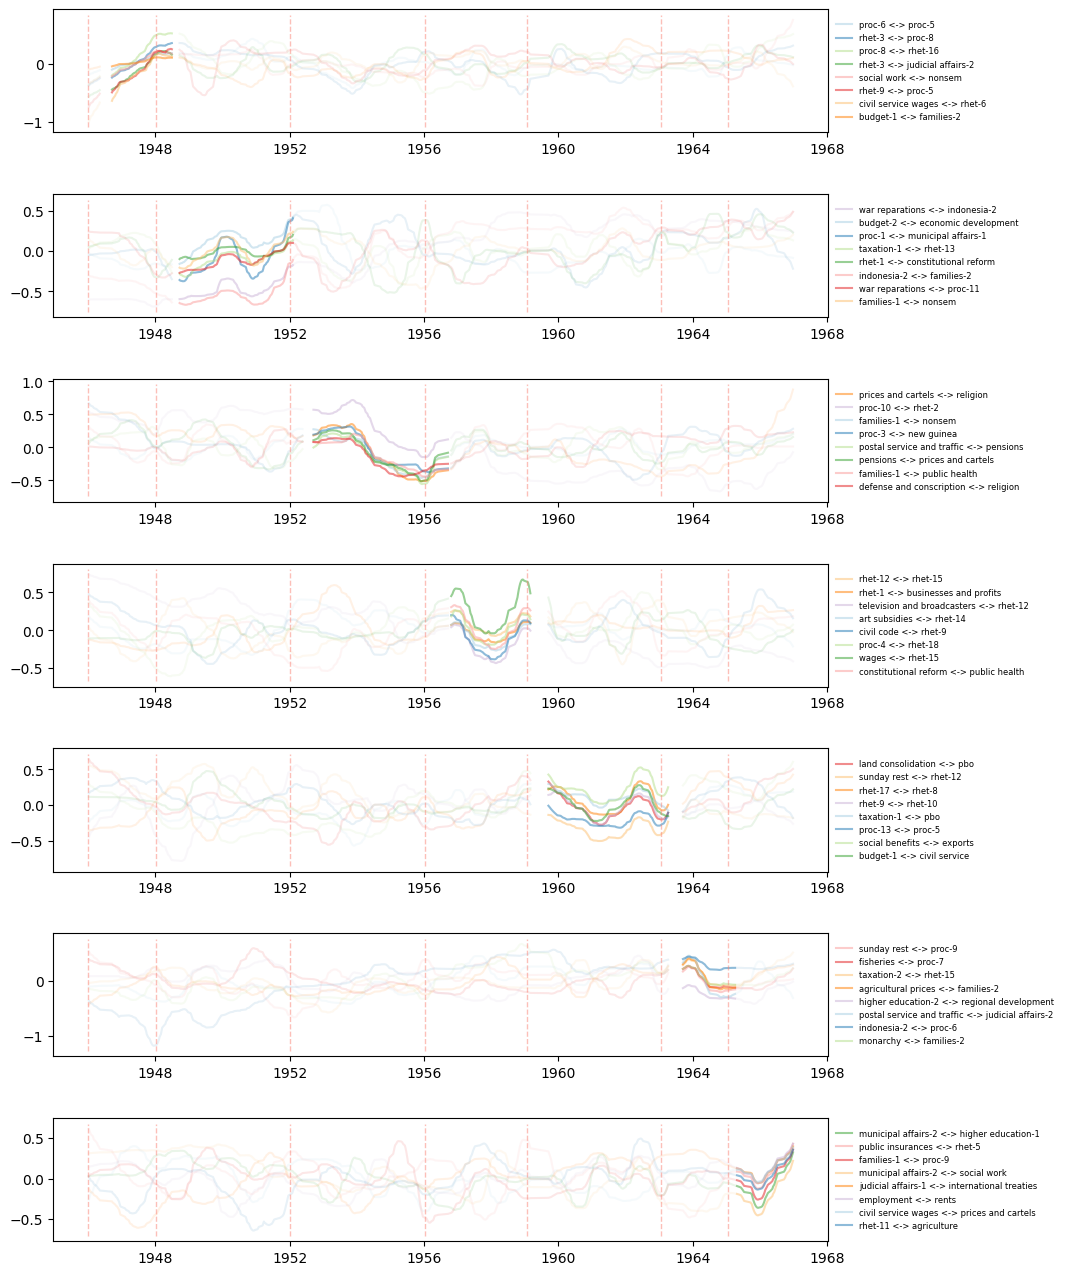

In [6]:
fig, axs = plt.subplots(7,1,figsize=(10,16))
topn = 8

pal = sns.color_palette('Paired',topn+1)
c_ = 0

for c,(cabinet,res) in enumerate(results.items()):
    meta = cab_[cab_.cabinet == cabinet].to_dict('records')[0]
    # corr_df_ = res['corr_df'][['corr','t1']].groupby('t1').mean().reset_index().sort_values('corr',ascending=False)
    corr_df_ = res['corr_df'].sort_values('corr',ascending=False)
    top_ = corr_df_.p.tolist()[:topn]
    # top_indices = [labels_reverse[l] for l in top_]

    for t in top_:
        # dfm_ = dfm[[c for c in dfm.columns if int(c.split('-')[0]) == t]].mean(axis=1).reset_index()
        dfm_ = dfm[t].reset_index()
        dfm_.columns = ['date','mean_linkage']
    #     # dfm_['mean_linkage'] = zscore(np.squeeze(np.asarray(adaptive_filter(dfm_.mean_linkage))))

        mask_target_period = (stats.date >= meta['startdate']) & (stats.date <= meta['enddate'])
        dfm_tp = dfm_.loc[mask_target_period]
        X = dfm_tp.date.tolist()
        Y = dfm_tp.mean_linkage.tolist()
        label_pair = labels[int(t.split('-')[0])] + ' <-> ' + labels[int(t.split('-')[1])] 
        # axs[c].plot(X,Y,color= pal[c_],alpha=.5,label=words[t][:50])
        axs[c].plot(X,Y,color= pal[c_],alpha=.5,label=label_pair)
        # axs[c].annotate(labels[t],xy=(X[0],Y[0]),color=pal[c])

        for i in range(2):
            dfm_mask_other_period = (stats.date <= meta['startdate']) if i == 0 else (stats.date > meta['enddate'])
            dfm_tp = dfm_.loc[dfm_mask_other_period]
            X = dfm_tp.date.tolist()
            Y = dfm_tp.mean_linkage.tolist()
            axs[c].plot(X,Y,alpha=.1,color=pal[c_],label=None)
        if c_ == topn:
            c_ = 0
        else:
            c_ += 1
    axs[c].legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=6)
    add_cabinet_periods(axs[c],fn='helpers/cabinets-merged.csv',text=False)
stats_ = stats[stats.date.dt.year > 1947]
# ax.plot(stats_.date,stats_.m_afa_z,linewidth=2,color='black')
plt.subplots_adjust(hspace=.5)
plt.show()

100%|██████████| 4950/4950 [00:00<00:00, 7741.81it/s]


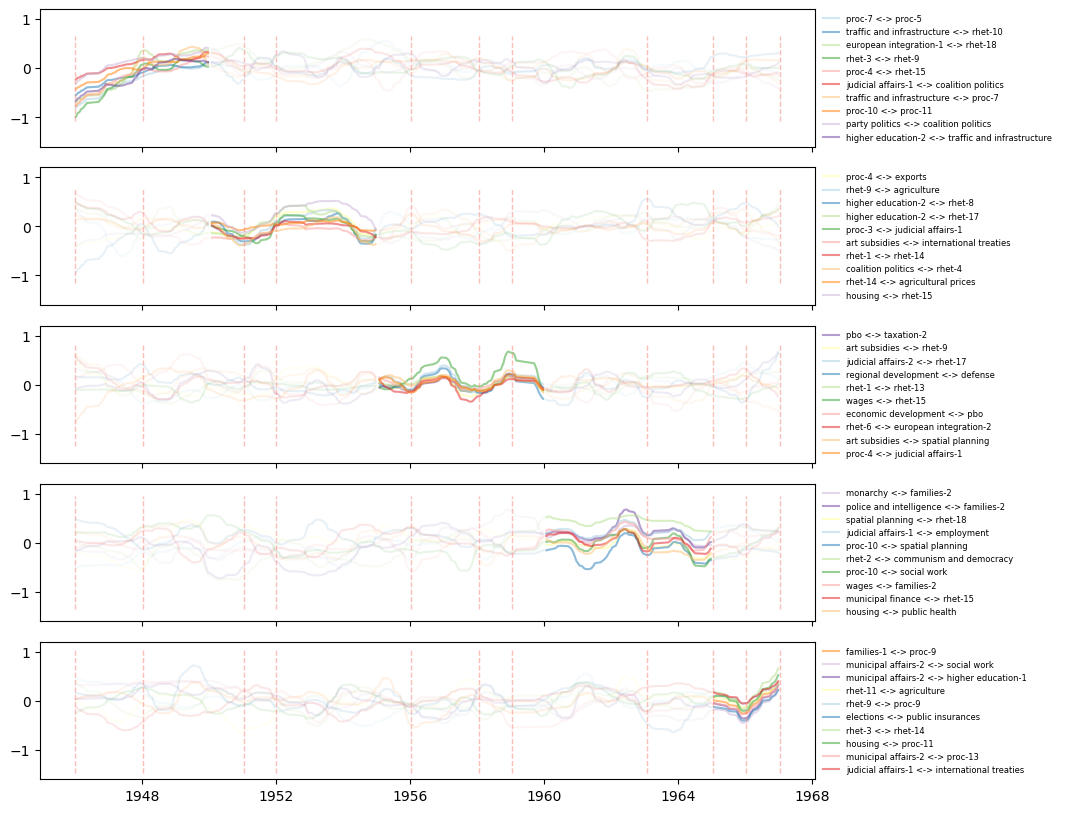

In [7]:
ranges = list(range(1945,1968,5))
ranges = [(r,r+5) for r in ranges]

fig, axs = plt.subplots(len(ranges),1,figsize=(10,10),sharey=True,sharex=True)
topn = 10

pal = sns.color_palette('Paired',topn+1)
c_ = 0

for c,(start,end) in enumerate(ranges):
    # Get Diachronic Normalized M per Cabinet
    mask = (stats.date.dt.year >= start) & (stats.date.dt.year < end)
    lkg_trend = stats.loc[mask]
    lkg_trend = lkg_trend.m_afa_z.to_numpy()

    # Subset Flattened MI DataFrame
    dfm_mask = (dfm.index.year >= start) & (dfm.index.year < end)
    dfm_ = dfm.loc[dfm_mask]

    dates, dfm_arr = dfm_.index.tolist(), dfm_.to_numpy()

    cls_ = dfm.columns
    corr_df = []

    # Loop over pairs, calculated standardized + denoised signal for time slice, calculate Pearson's R
    for i in tqdm(range(dfm_arr.shape[1])):
        corr = np.corrcoef(lkg_trend,dfm_arr[:,i])[0,1]
        corr_df.append((cls_[i],corr))

    corr_df = pd.DataFrame(corr_df,columns=['p','corr'])
    corr_df[['t1','t2']] = corr_df.p.str.split(pat='-',n=1,expand=True)
    corr_df[['t1','t2']] = corr_df[['t1','t2']].applymap(lambda x: labels[int(x)])

    corr_df_ = corr_df.sort_values('corr',ascending=False)
    top_ = corr_df_.p.tolist()[:topn]

    for t in top_:
        dfm_ = dfm[t].reset_index()
        dfm_.columns = ['date','mean_linkage']

        mask_target_period = (stats.date.dt.year >= start) & (stats.date.dt.year < end)
        dfm_tp = dfm_.loc[mask_target_period]
        X = dfm_tp.date.tolist()
        Y = dfm_tp.mean_linkage.tolist()
        label_pair = labels[int(t.split('-')[0])] + ' <-> ' + labels[int(t.split('-')[1])] 
        axs[c].plot(X,Y,color= pal[c_],alpha=.5,label=label_pair)

        for i in range(2):
            dfm_mask_other_period = (stats.date.dt.year < start) if i == 0 else (stats.date.dt.year >= end)
            dfm_tp = dfm_.loc[dfm_mask_other_period]
            X = dfm_tp.date.tolist()
            Y = dfm_tp.mean_linkage.tolist()
            axs[c].plot(X,Y,alpha=.1,color=pal[c_],label=None)
        if c_ == topn:
            c_ = 0
        else:
            c_ += 1
    axs[c].legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=6)
    add_cabinet_periods(axs[c],fn='helpers/cabinets.csv',text=False)
stats_ = stats[stats.date.dt.year > 1947]
# ax.plot(stats_.date,stats_.m_afa_z,linewidth=2,color='black')
plt.subplots_adjust(hspace=.15)
plt.show()

In [8]:
def plot_linkage_lines_topic(dfm,topic_index):
    fig,ax=plt.subplots(1,1,figsize=(4,3))
    # dfm_ = dfm[[c for c in dfm.columns if int(c.split('-')[0]) == topic_index or int(c.split('-')[1]) == topic_index]].reset_index()
    dfm_ = dfm[[c for c in dfm.columns if int(c.split('-')[0]) == topic_index or int(c.split('-')[1]) == topic_index]].mean(axis=1).reset_index()
    # if ci == True:
    #     dfm_ = pd.melt(dfm_,id_vars='date')
    #     sns.lineplot(data=dfm_,x='date',y='value',ax=ax)
    # else:
    #     dfm_.plot(x='date',y=list(dfm_.columns)[1:],cmap='Blues',ax=ax,legend=False)
    dfm_.plot(x='date',y=0,ax=ax,legend=False)
    ax.set_title(labels[topic_index] + '\n' + words[topic_index][:25],fontsize=10)
    # add_cabinet_periods(ax)
    plt.show()

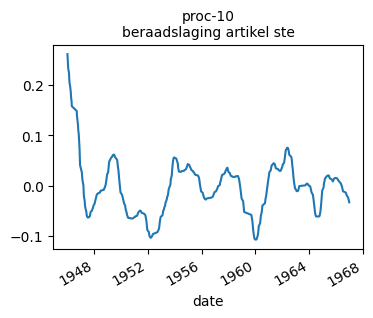

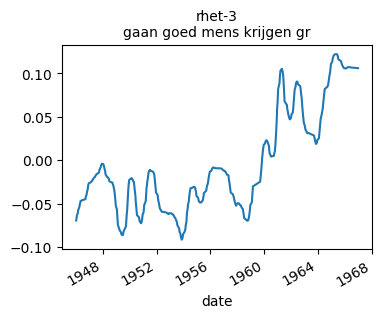

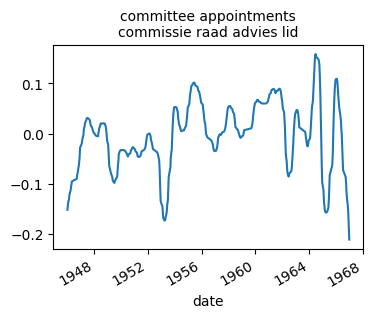

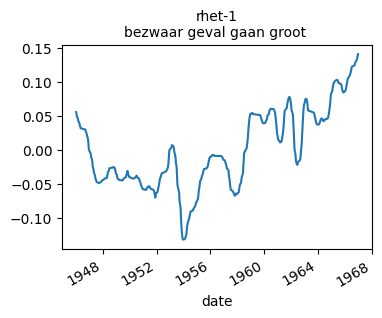

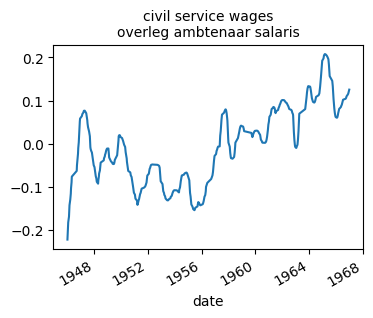

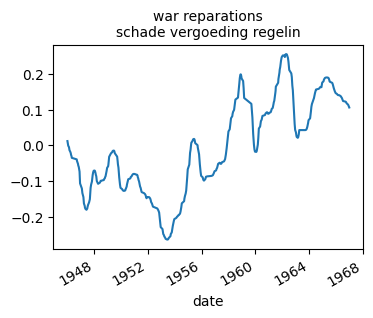

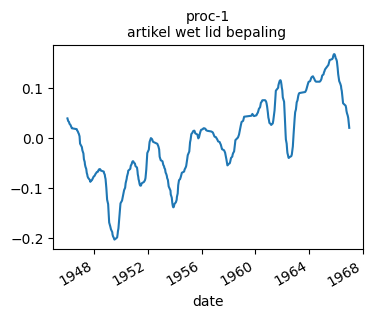

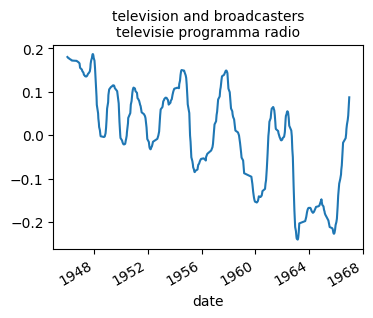

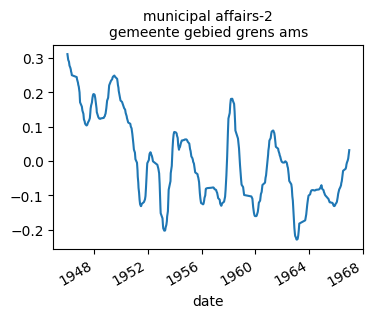

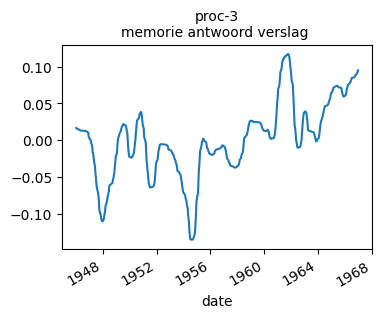

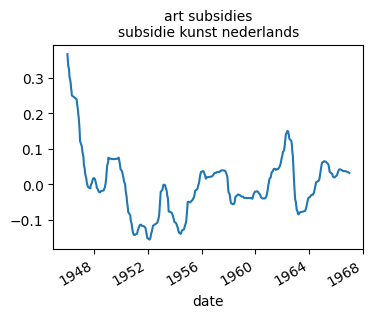

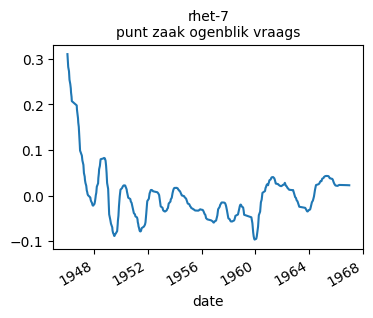

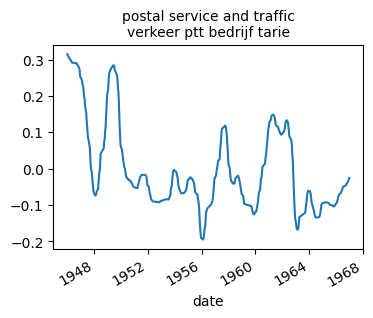

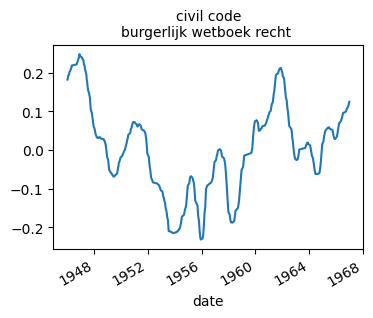

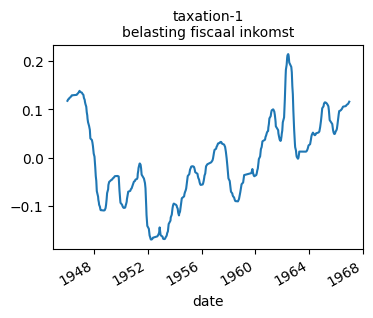

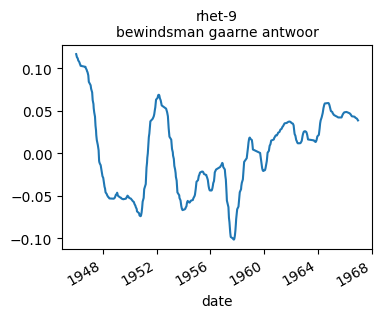

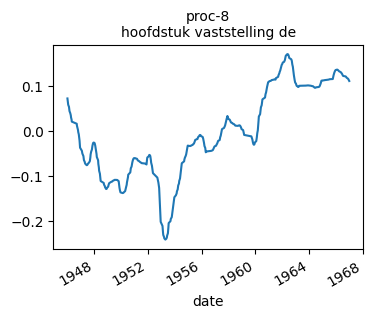

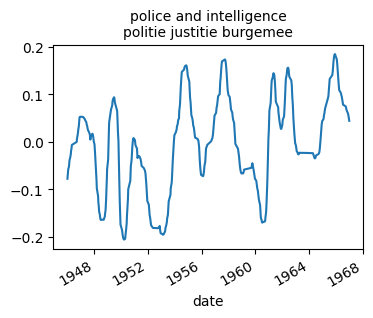

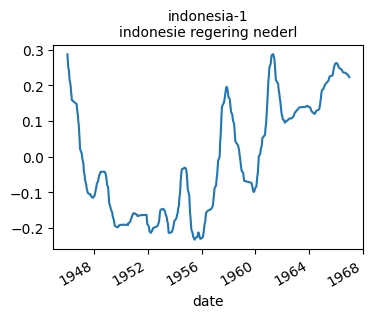

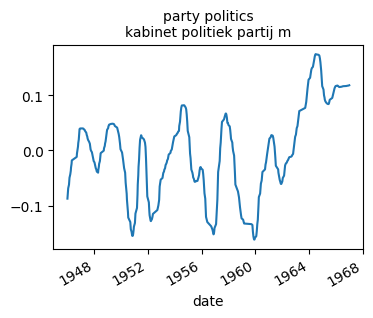

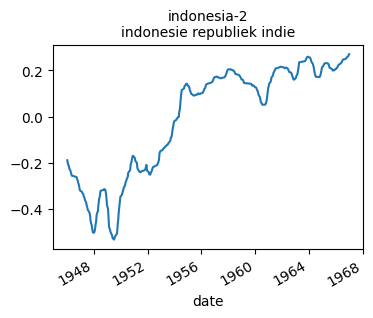

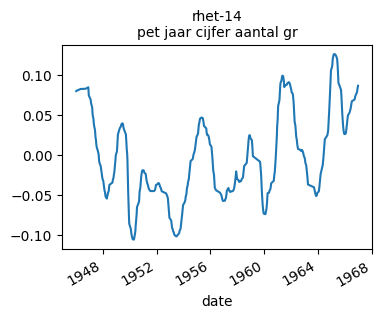

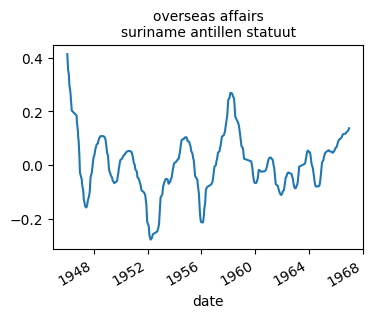

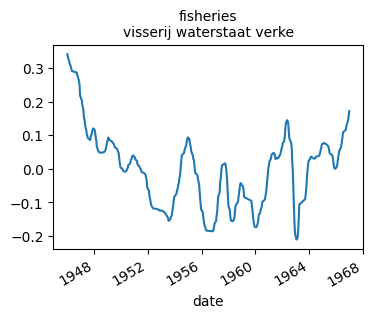

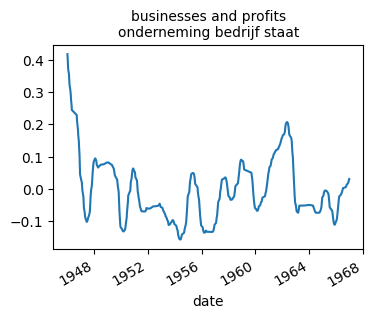

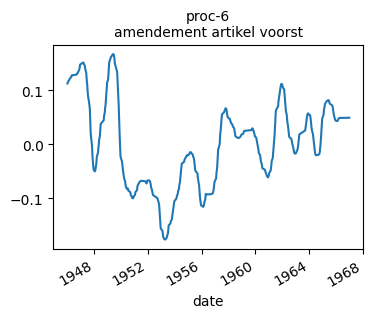

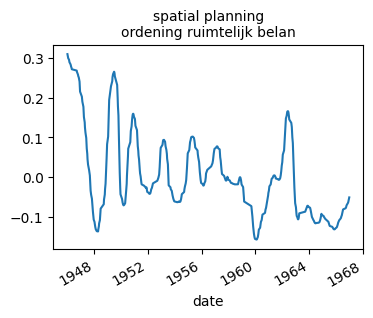

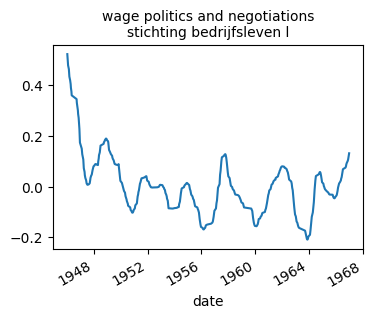

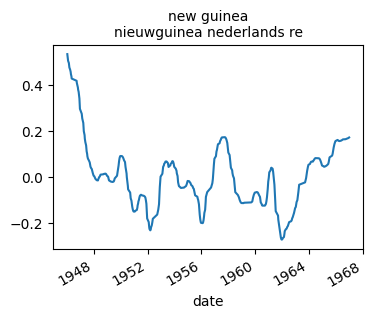

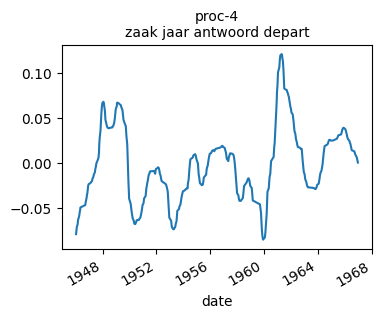

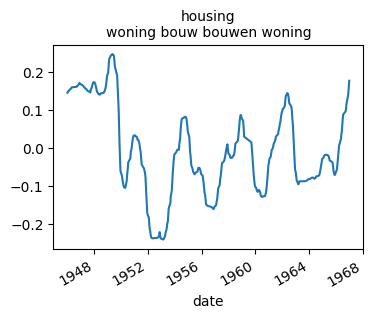

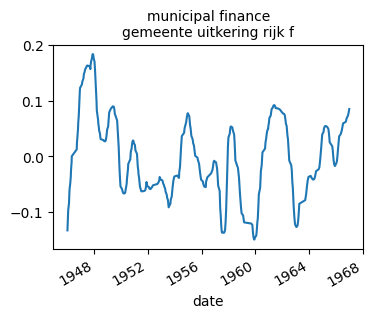

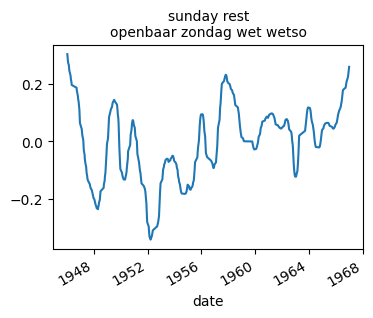

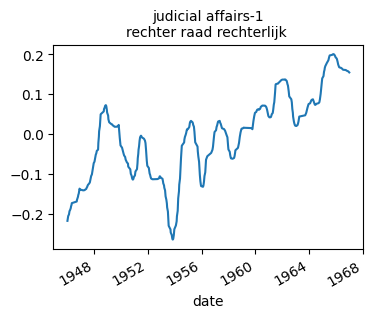

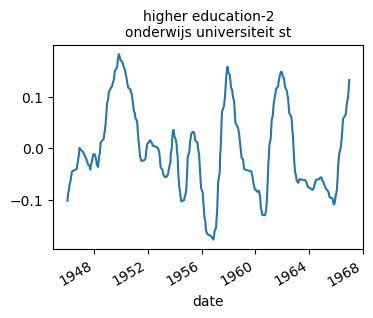

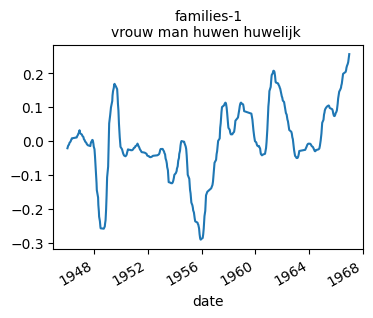

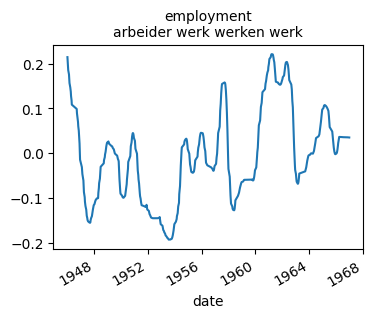

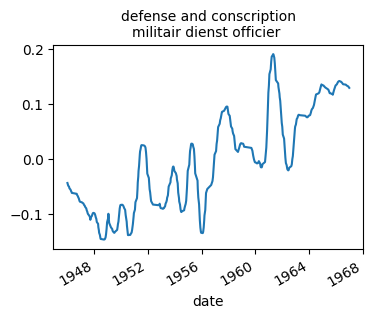

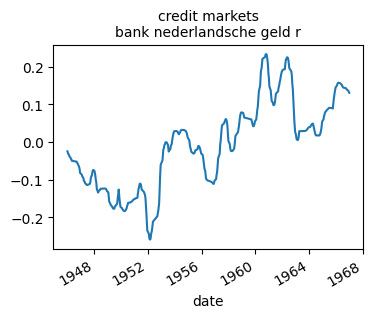

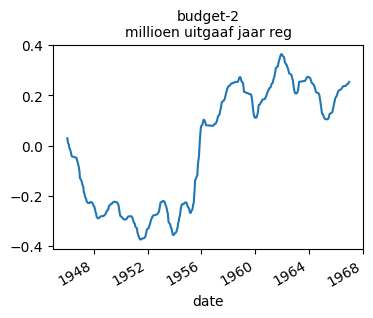

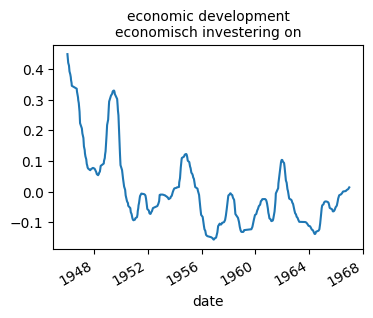

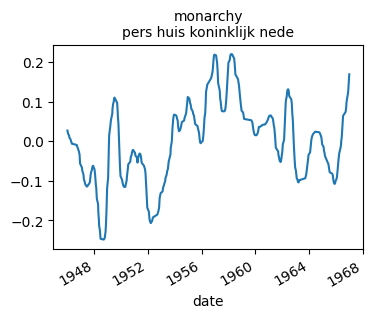

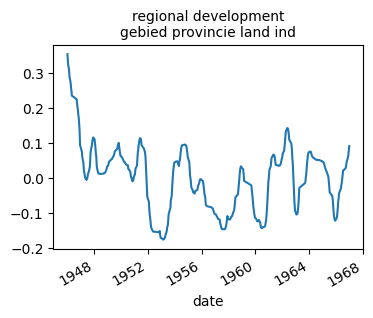

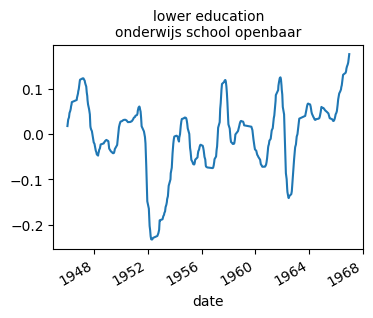

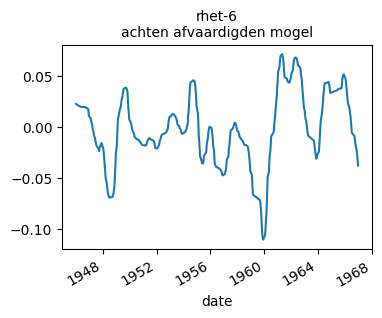

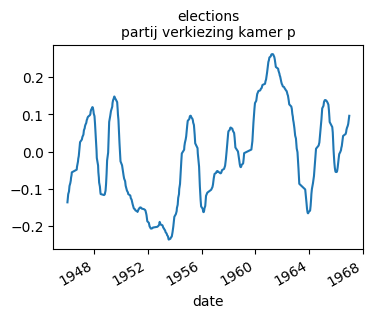

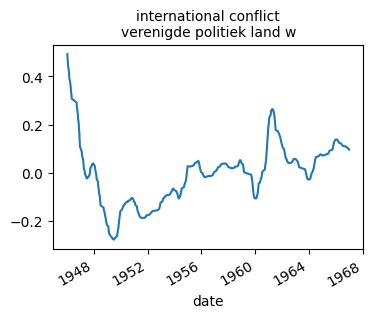

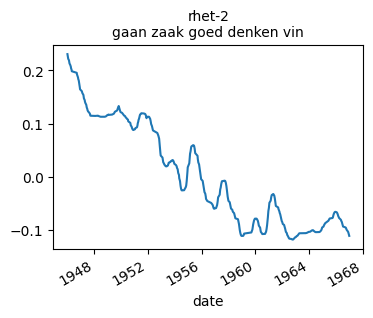

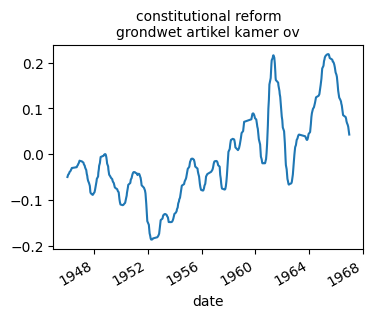

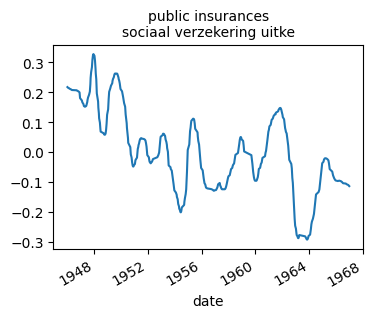

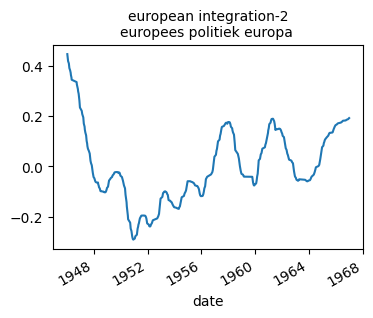

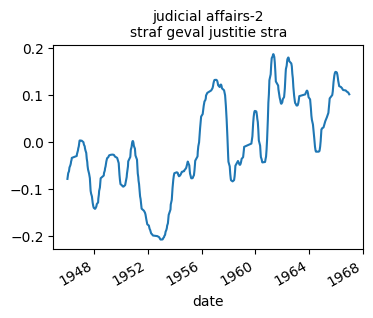

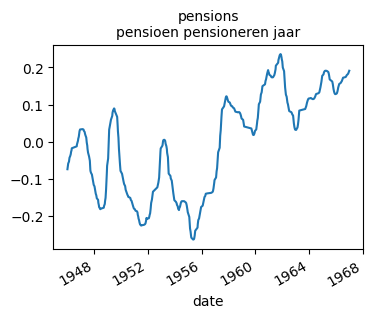

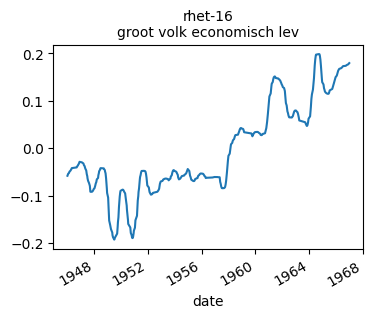

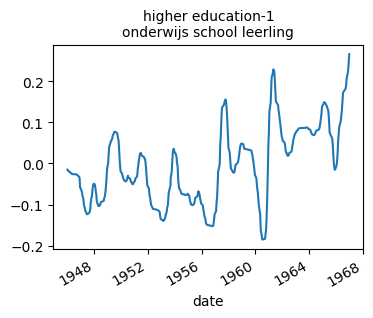

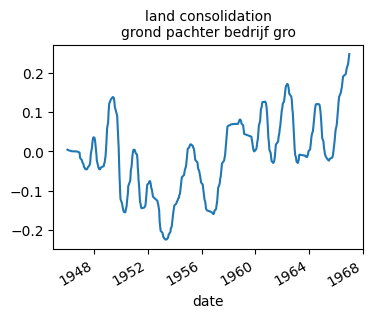

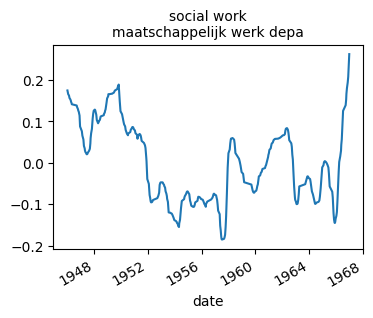

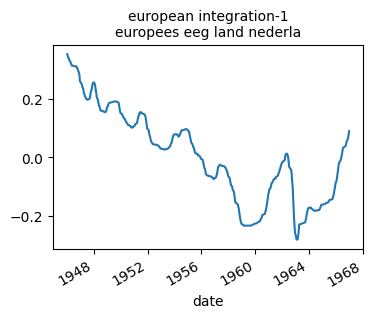

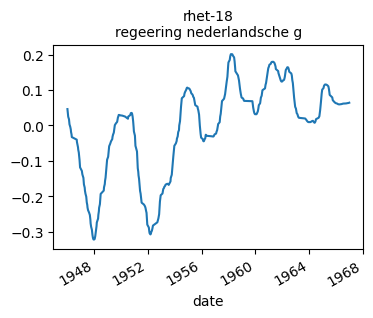

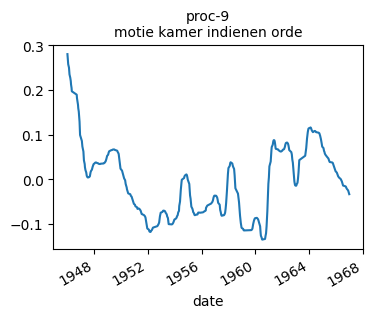

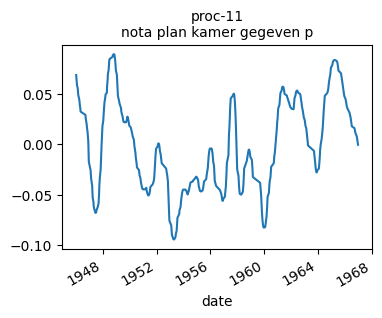

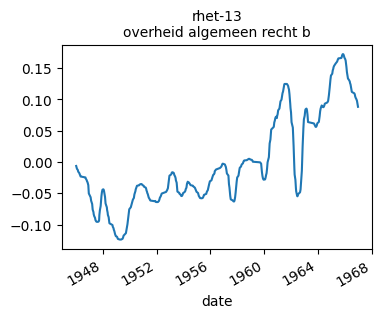

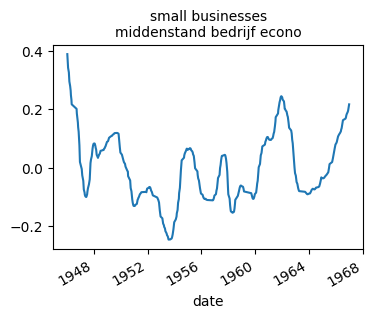

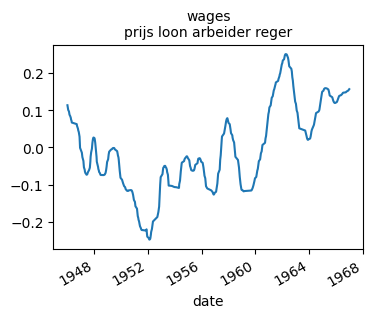

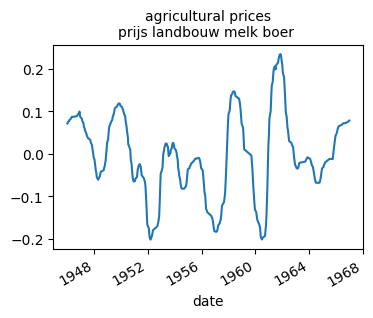

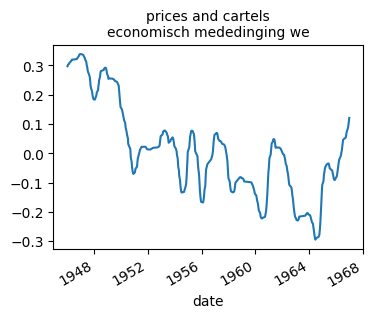

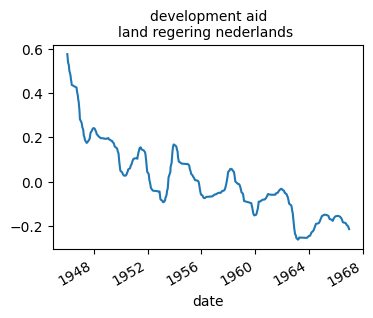

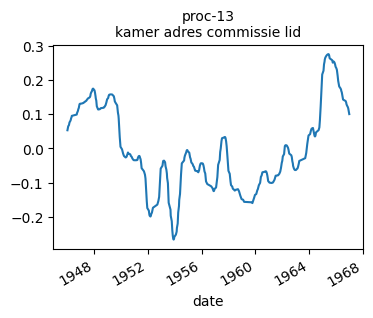

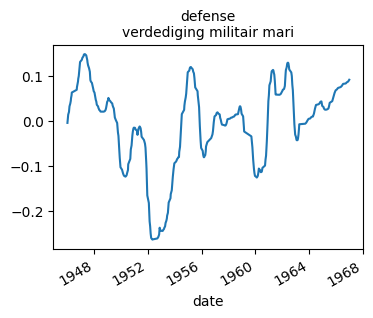

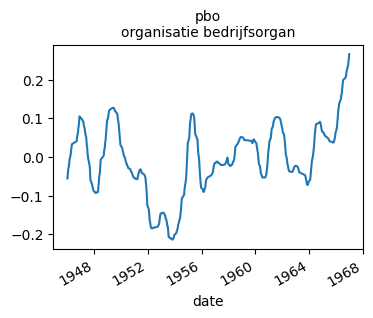

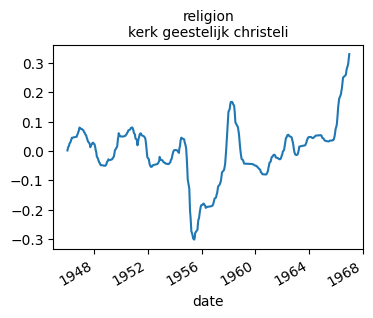

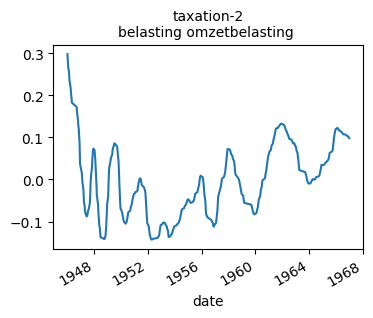

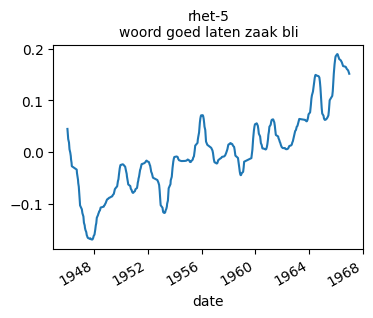

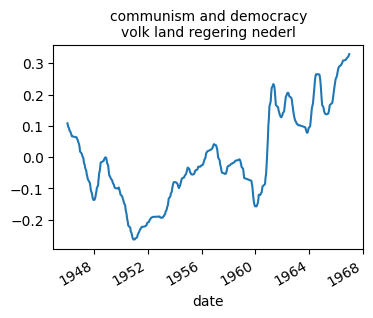

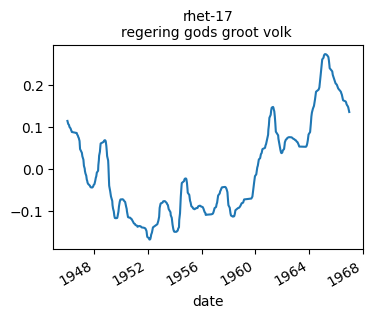

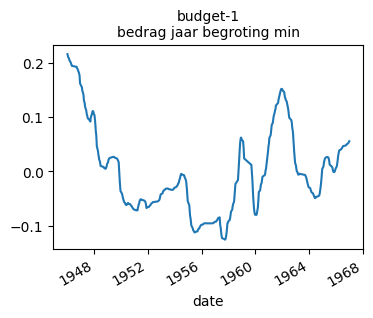

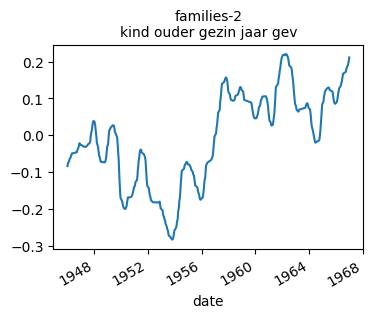

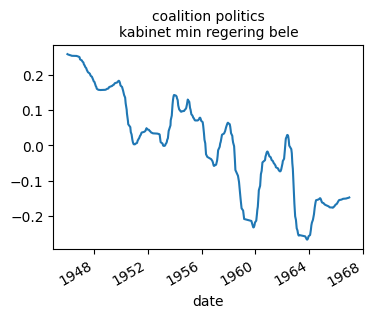

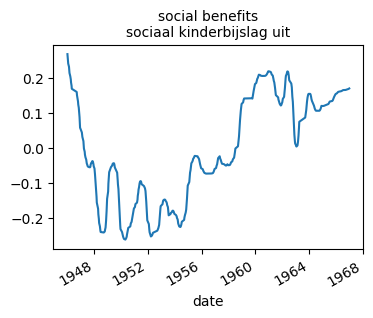

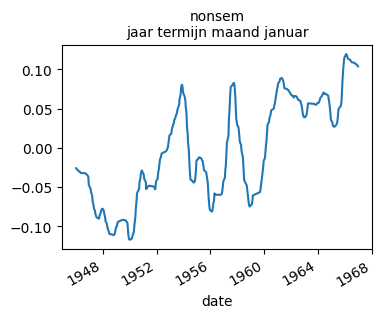

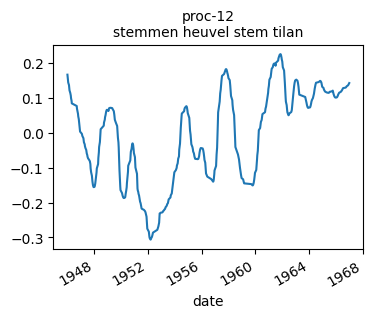

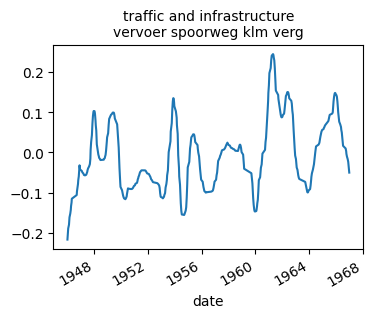

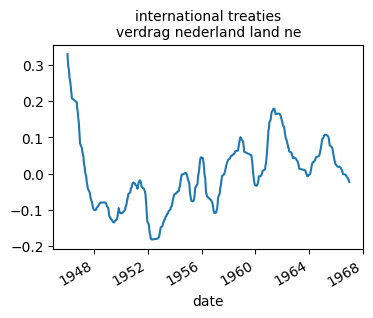

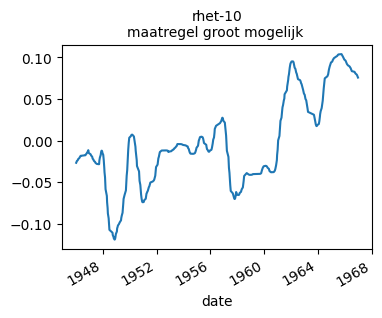

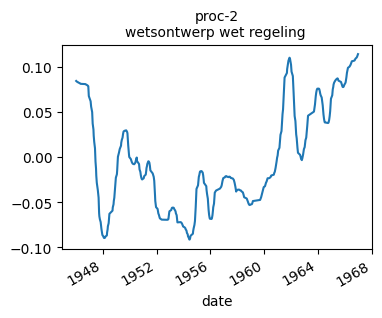

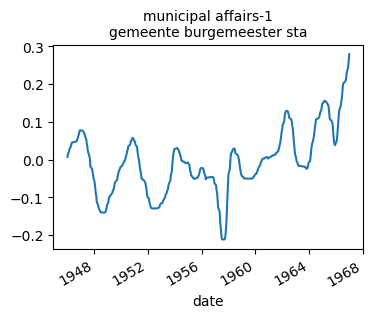

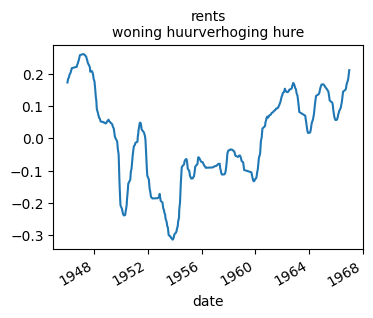

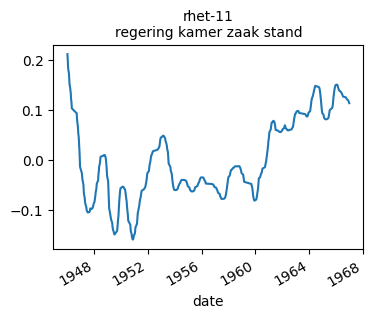

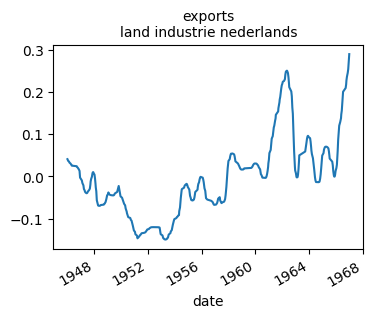

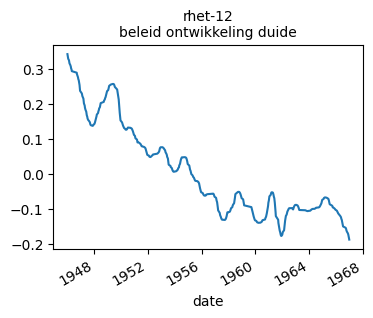

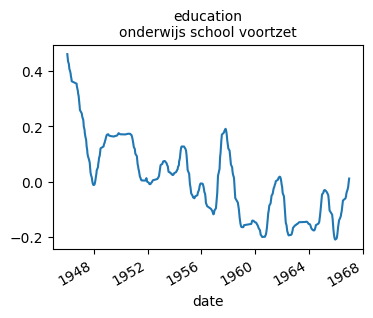

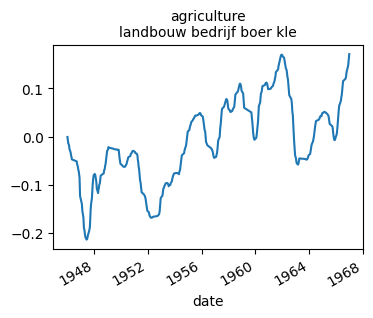

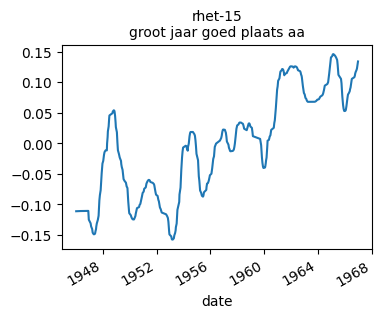

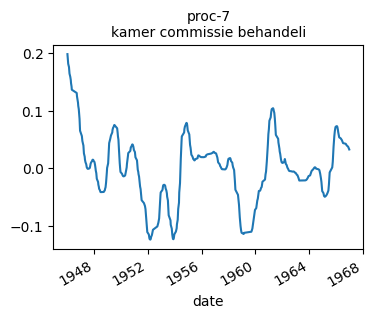

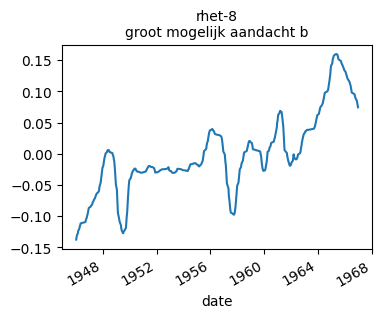

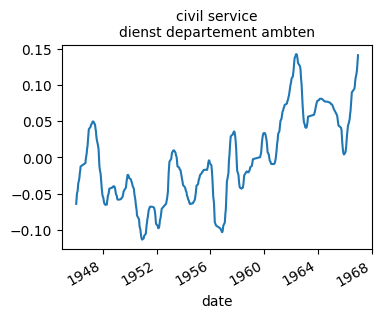

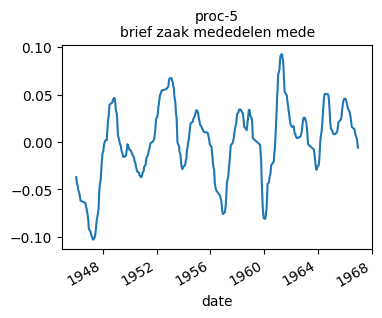

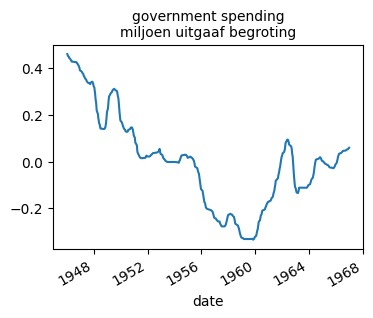

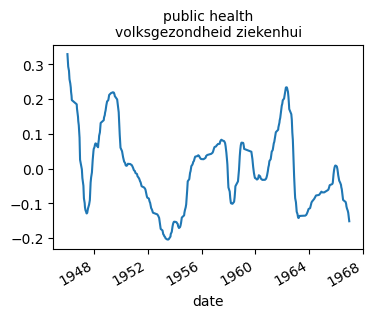

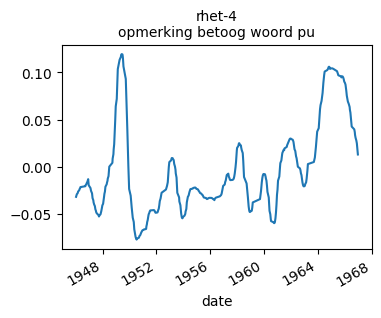

In [9]:
for i in range(100):
    plot_linkage_lines_topic(dfm,i)

100%|██████████| 4950/4950 [00:00<00:00, 9749.58it/s] 


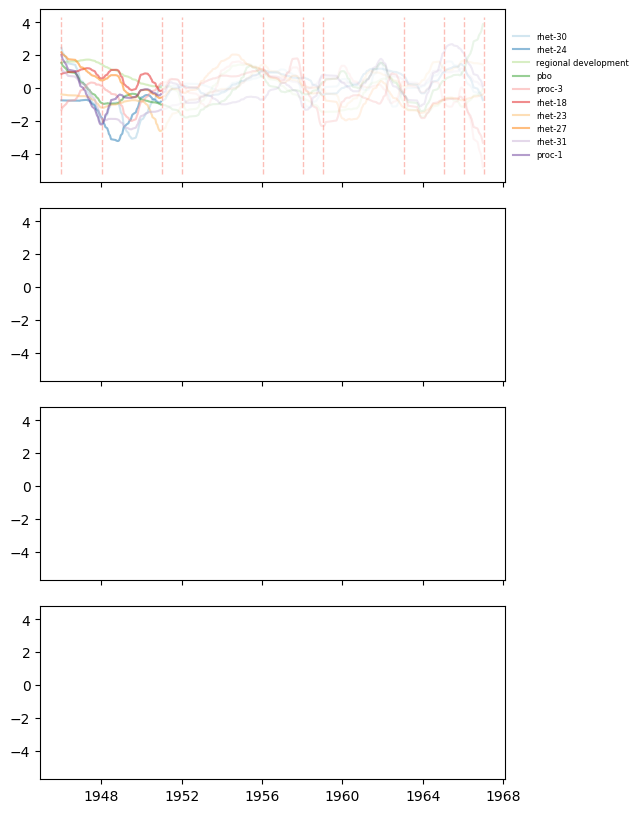

In [109]:
ranges = list(range(1945,1968,6))
ranges = [(r,r+6) for r in ranges]

fig, axs = plt.subplots(len(ranges),1,figsize=(6,10),sharey=True,sharex=True)
topn = 10

pal = sns.color_palette('Paired',topn+1)
c_ = 0

for c,(start,end) in enumerate(ranges):
    # Get Diachronic Normalized M per Cabinet
    mask = (stats.date.dt.year >= start) & (stats.date.dt.year < end)
    lkg_trend = stats.loc[mask]
    lkg_trend = lkg_trend.m_afa_z.to_numpy()

    # Subset Flattened MI DataFrame
    dfm_mask = (dfm.index.year >= start) & (dfm.index.year < end)
    dfm_ = dfm.loc[dfm_mask]

    dates, dfm_arr = dfm_.index.tolist(), dfm_.to_numpy()

    cls_ = dfm.columns
    corr_df = []

    # Loop over pairs, calculated standardized + denoised signal for time slice, calculate Pearson's R
    for i in tqdm(range(dfm_arr.shape[1])):
        corr = np.corrcoef(lkg_trend,dfm_arr[:,i])[0,1]
        corr_df.append((cls_[i],corr))

    corr_df = pd.DataFrame(corr_df,columns=['p','corr'])
    corr_df[['t1','t2']] = corr_df.p.str.split(pat='-',n=1,expand=True)
    corr_df[['t1','t2']] = corr_df[['t1','t2']].applymap(lambda x: labels[int(x)])
    
    corr_df_ = corr_df[['corr','t1']].groupby('t1').mean().reset_index().sort_values('corr',ascending=False)
    top_ = corr_df_.t1.tolist()[:topn]
    top_indices = [labels_reverse[l] for l in top_]

    for t in top_indices:
        dfm_ = dfm[[c for c in dfm.columns if int(c.split('-')[0]) == t or int(c.split('-')[1]) == t]].mean(axis=1).reset_index()
        dfm_.columns = ['date','mean_linkage']
        dfm_['mean_linkage'] = zscore(np.squeeze(np.asarray(adaptive_filter(dfm_.mean_linkage))))

        mask_target_period = (stats.date.dt.year >= start) & (stats.date.dt.year < end)
        dfm_tp = dfm_.loc[mask_target_period]
        X = dfm_tp.date.tolist()
        Y = dfm_tp.mean_linkage.tolist()
        axs[c].plot(X,Y,color= pal[c_],alpha=.5,label=labels[t])

        for i in range(2):
            dfm_mask_other_period = (stats.date.dt.year < start) if i == 0 else (stats.date.dt.year >= end)
            dfm_tp = dfm_.loc[dfm_mask_other_period]
            X = dfm_tp.date.tolist()
            Y = dfm_tp.mean_linkage.tolist()
            axs[c].plot(X,Y,alpha=.1,color=pal[c_],label=None)
        if c_ == topn:
            c_ = 0
        else:
            c_ += 1
    axs[c].legend(loc='center left', bbox_to_anchor=(1, 0.5),frameon=False,fontsize=6)
    add_cabinet_periods(axs[c],fn='helpers/cabinets.csv',text=False)
    break

stats_ = stats[stats.date.dt.year > 1947]
# ax.plot(stats_.date,stats_.m_afa_z,linewidth=2,color='black')
plt.subplots_adjust(hspace=.15)
plt.show()